What are the peculiar velocities of the Fuji TF galaxies?

In [19]:
import numpy as np

from astropy.io import fits
from astropy.table import Table
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import Distance
from astropy.cosmology import Planck18

from scipy.stats import binned_statistic

import pickle

import matplotlib.pyplot as plt

In [2]:
c = const.c.to('km/s')

## Profile Histogram Code

Here we use "profile histogram" in the sense of the ROOT CERN package. This just produces data suitable for plotting in an errorbar plot showing binned statistics (mean, weighted mean, or median) as a function of some independent variable.

**Note:** This was copied from `Y1/TF_PV_corr_checks.ipynb`

In [13]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

# Data

SGA catalog with computed peculiar velocities

In [3]:
# hdul = fits.open('SGA_fuji_jointTFR-varyV0-perpdwarf_moduli_pec-Watkins15.fits')
hdul = fits.open('SGA_fuji_jointTFR-varyV0-perpdwarf-zCMB_moduli_pec-Watkins15.fits')
hdr = hdul[0].header
SGA_TF = Table(hdul[1].data)
hdul.close()

H0 = hdr['H0']

SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_ERR,TARGETID,PHOTSYS,Z_DESI_CMB,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,MU_zCMB,MU_zCMB_ERR,R_ABSMAG_SB26,R_ABSMAG_SB26_ERR,R_ABSMAG_SB26_CORR,R_ABSMAG_SB26_CORR_ERR,R_ABSMAG_SB26_TFbright,R_ABSMAG_SB26_TFbright_err,MU_TFbright,MU_TFbright_ERR,LOGDIST,LOGDIST_ERR,V_PEC,VERR_PEC
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.00571239

Peculiar velocities from FP

In [4]:
FP = Table.read('../../SV/DESI_FP_logdists_fiducial.csv', format='ascii.commented_header')
FP[:5]

fibermap_targetid,fibermap_i,ra_1,dec_1,targetid,id,healpix,survey,program,targetid.1,z_x,zerr,zwarn,spectype,subtype,deltachi2,healpix_id,targetid.2,target_ra,target_dec,obsconditions,release,brickid_1,brick_objid,fiberflux_ivar_g,fiberflux_ivar_r,fiberflux_ivar_z,morphtype,flux_g,flux_r,flux_z,flux_ivar_g,flux_ivar_r,flux_ivar_z,ebv,flux_w1,flux_w2,flux_ivar_w1,flux_ivar_w2,fiberflux_g,fiberflux_r,fiberflux_z,fibertotflux_g,fibertotflux_r,fibertotflux_z,sersic_1,coadd_numexp,coadd_exptime,coadd_numnight,coadd_numtile,healpix_id.1,objid_1,brickid.1,brickname_1,ra.1,dec.1,ppxf_sigma,ppxf_sigma_error,DER_SNR,snr_ppxf,OBJID_2,BRICKID_2,BRICKNAME_2,RA_2,DEC_2,TYPE,SERSIC_2,Z_PHOT_MEDIAN,Z_PHOT_L95,mag_g,mag_r,mag_z,mag_B,mag_g_err,mag_r_err,mag_z_err,fibre_mag_g,fibre_mag_r,fibre_mag_z,uncor_radius,BA_ratio,circ_radius,uncor_radius_err,err_shape_e1,err_shape_e2,pos_angle,Separation,mag_r_corrected,BA_ratio_error,TargetId,tmass,flag,z_y,rmag,g_r_PS1_5_cor,W2_W3,W2_W3_err,PS1_ibumpy,zcmb,zcmb_group,dz,dz_group,r,er,kcor_r,kcor_g,i,ei,s,es,absmag_r,Sn,logdist,logdist_err,logdist_alpha,pv,pverr
int64,int64,float64,float64,int64,int64,int64,str3,str6,int64,float64,float64,int64,str6,int64,float64,int64,int64,float64,float64,int64,int64,int64,int64,str5,int64,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,int64,int64,int64,int64,str8,float64,float64,float64,float64,float64,float64,int64,int64,str8,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str22,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628417112478213,400,192.260476663904,26.8931119632851,39628417112478213,1301,28148,sv1,bright,39628417112478213,0.0246198717561043,3.05679754892841e-06,0,GALAXY,--,208858.610858595,1301,39628417112478213,192.260476663904,26.8931119632851,4,9010,481140,4613,False,--,--,SER,718.737670898438,1493.39233398438,2632.02905273438,12.3129425048828,3.62823224067688,2.14227867126465,0.0110182352364063,1792.16967773438,1005.01934814453,-1.0,-1.0,84.9578857421875,176.525405883789,311.1171875,84.9578857421875,176.525405883789,311.1171875,3.24683547019958,15,6695.12646484375,7,1,1301,4613,481140,1921p270,192.260476663904,26.8931119632851,138.97191401554343,1.3838325204676758,50.32823792570804,37.09863394208711,4613,481140,1921p270,192.26047666390429,26.89311196328508,SER,3.2468355,0.023591544,0.018623924,15.323162,14.54071,13.93593,15.744,0.00041668504,0.00037338858,0.00027839307,17.641579,16.859127,16.254347,5.18443,0.3502856,3.068401,0.001138905,0.00015687887,0.00016151024,-22.695267,9.032862052074111e-10,14.54071,0.0001115389190186,39628417112478213,2MASXJ12490248+2653350,1,0.0246,14.367,0.643,0.902,0.145,0.216,0.02556977744883837,0.02556977744883837,76.1982724818877,76.1982724818877,0.04386937487526493,0.00011782648155669783,0.02503684213839932,0.04334819959542904,2.9441341941217747,0.0002789970682498833,2.154576602686897,0.004324548825517668,-19.92513203057605,1.0,0.04082911658524023,0.10087512604970075,-0.21153047623097235,716.01186967735,1769.0264607119864
39628417133447721,426,193.57922538261,27.0680307191934,39628417133447721,1304,28149,sv1,bright,39628417133447721,0.0278119786253126,2.6882528734125e-06,0,GALAXY,--,648939.39017427,1304,39628417133447721,193.57922538261,27.0680307191934,4,9010,481145,2601,--,--,--,SER,5968.87890625,12903.7099609375,23318.6015625,1.23958659172058,0.327169686555862,0.208652123808861,0.008288275450468,16008.04296875,9302.5791015625,-1.0,-1.0,225.581344604492,487.668823242188,881.277954101562,225.581451416016,487.669097900391,881.278625488281,4.501549243927,15,6695.12646484375,

# Identify "dwarf" galaxies

In [5]:
temp_infile = open('cov_ab_fuji_joint_TFR_varyV0-perpdwarfs0_KAD.pickle', 'rb')
cov_ab, tfr_samples, V0 = pickle.load(temp_infile)
temp_infile.close()

In [6]:
slope = np.median(tfr_samples[0])
slope_err = np.sqrt(cov_ab[0,0])

ZP = np.median(tfr_samples[2])
ZP_err = np.sqrt(cov_ab[2,2])

In [7]:
logV_n17 = (-17 - ZP)/slope + V0
b_perp = -17 + (1/slope)*(logV_n17 - V0)

dwarf_boolean = (SGA_TF['R_ABSMAG_SB26_CORR'] - SGA_TF['R_ABSMAG_SB26_CORR_ERR']) > (-(np.log10(SGA_TF['V_0p33R26']) - V0)/slope + b_perp)

In [8]:
print('SGA galaxies with distance moduli:', len(SGA_TF))
print('non-"dwarf" SGA galaxies with distance moduli:', len(SGA_TF) - sum(dwarf_boolean))

SGA galaxies with distance moduli: 1164
non-"dwarf" SGA galaxies with distance moduli: 1137


# Compute the maximum distance within which each galaxy would be included in the SGA

We are using the observed redshift because this is what determines the apparent size of the galaxy.

In [16]:
SGA_TF['DIST'] = Distance(z=np.abs(SGA_TF['Z_DESI']), cosmology=Planck18)

SGA_TF['D26_kpc'] = 2*SGA_TF['DIST'].to('kpc')*np.tan(0.5*SGA_TF['D26']*u.arcmin)

SGA_TF['DIST_MAX'] = 0.5*SGA_TF['D26_kpc']/np.tan(0.1*u.arcmin)

# Plots

In [9]:
bin_width = 1500 # km/s
v_min = -41000
v_max = -v_min

v_bins = np.arange(v_min, v_max, bin_width)
vnorm_bins = np.arange(-20, 20, 1)

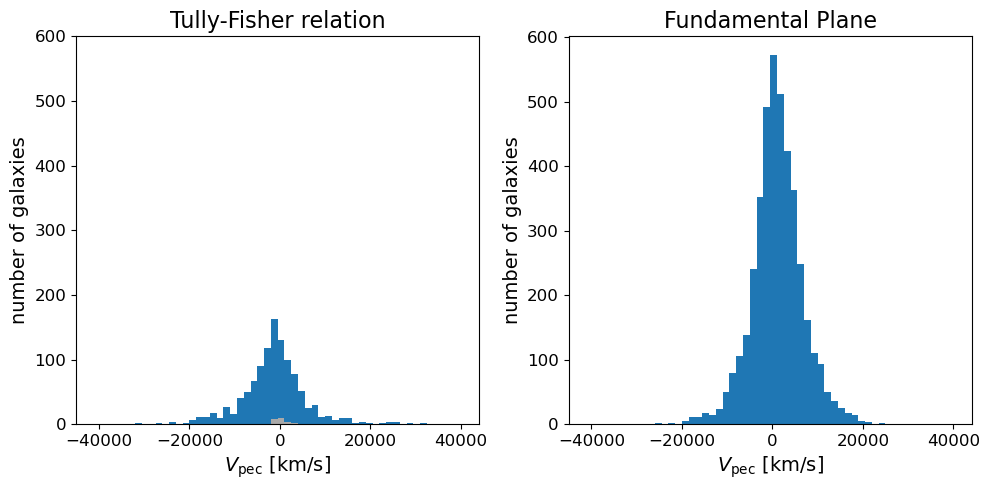

In [10]:
plt.figure(figsize=(10,5), tight_layout=True)

plt.subplot(121)
plt.title('Tully-Fisher relation', fontsize=16)
plt.hist(SGA_TF['V_PEC'][~dwarf_boolean], bins=v_bins)
plt.hist(SGA_TF['V_PEC'][dwarf_boolean], bins=v_bins, color='darkgray')
plt.ylim(ymax=600)
plt.xlabel(r'$V_\text{pec}$ [km/s]', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(122)
plt.title('Fundamental Plane', fontsize=16)
plt.hist(FP['pv'], bins=v_bins)
plt.xlabel(r'$V_\text{pec}$ [km/s]', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12);

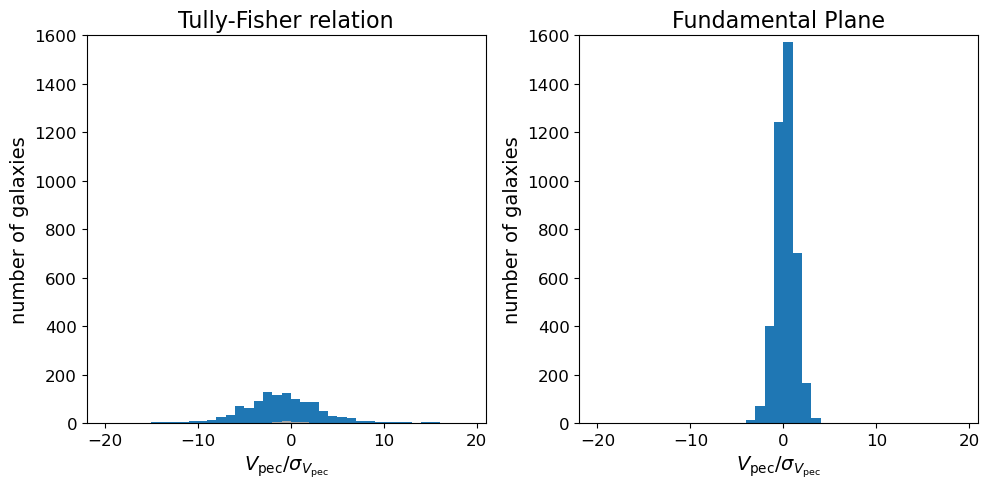

In [11]:
plt.figure(figsize=(10,5), tight_layout=True)

plt.subplot(121)
plt.title('Tully-Fisher relation', fontsize=16)
plt.hist(SGA_TF['V_PEC'][~dwarf_boolean]/SGA_TF['VERR_PEC'][~dwarf_boolean], bins=vnorm_bins)
plt.hist(SGA_TF['V_PEC'][dwarf_boolean]/SGA_TF['VERR_PEC'][dwarf_boolean], bins=vnorm_bins, color='darkgray')
plt.ylim(ymax=1600)
plt.xlabel(r'$V_\text{pec} / \sigma_{V_\text{pec}}$', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(122)
plt.title('Fundamental Plane', fontsize=16)
plt.hist(FP['pv']/FP['pverr'], bins=vnorm_bins)
plt.ylim(ymax=1600)
plt.xlabel(r'$V_\text{pec} / \sigma_{V_\text{pec}}$', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12);

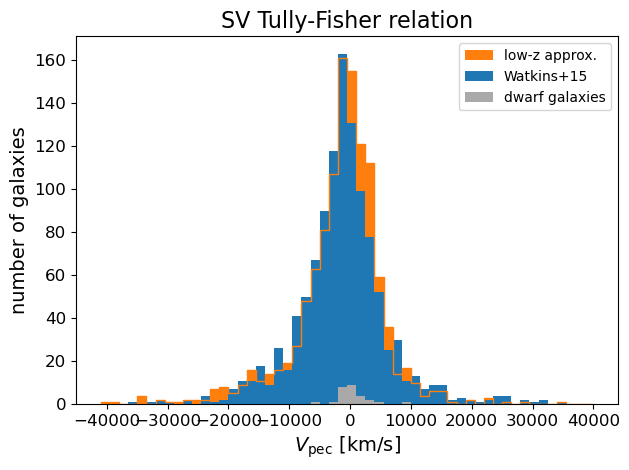

In [12]:
# Tamara wants to know how these estimates compare with what we originally calculated

# Previous calibration / calculation
oldSGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA_fuji_jointTFR-varyV0-perpdwarf_moduli_pec.fits')

plt.figure(tight_layout=True)

# plt.subplot(121)
plt.title('SV Tully-Fisher relation', fontsize=16)
plt.hist(oldSGA_TF['V_PEC'], bins=v_bins, color='tab:orange', label='low-z approx.')
plt.hist(SGA_TF['V_PEC'][~dwarf_boolean], bins=v_bins, color='tab:blue', label='Watkins+15')
plt.hist(SGA_TF['V_PEC'][dwarf_boolean], bins=v_bins, color='darkgray', label='dwarf galaxies')
plt.hist(oldSGA_TF['V_PEC'], bins=v_bins, color='tab:orange', histtype='step')
# plt.ylim(ymax=2000)
# plt.yscale('log')
plt.legend()
plt.xlabel(r'$V_\text{pec}$ [km/s]', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12);

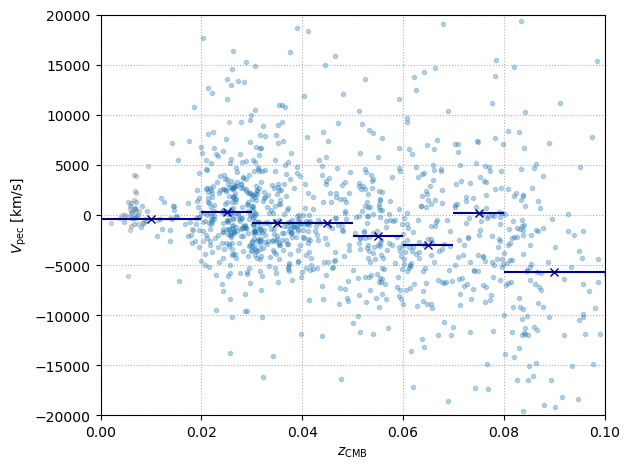

In [33]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

plt.figure(tight_layout=True)

plt.plot(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], SGA_TF['V_PEC'][~dwarf_boolean], '.', alpha=0.3)
plt.plot(SGA_TF['Z_DESI_CMB'][dwarf_boolean], SGA_TF['V_PEC'][dwarf_boolean], '.', c='gray', alpha=0.3)

# Plot the mean, weighted by Vmax
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
                                    SGA_TF['V_PEC'][~dwarf_boolean], 
                                    zbins, 
                                    weights=SGA_TF['DIST_MAX'][~dwarf_boolean].to('Gpc')**3, 
                                    weighted=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue')

plt.xlim([0, 0.1])
plt.ylim([-20000, 20000])

plt.xlabel(r'$z_{\text{CMB}}$')
plt.ylabel(r'$V_\text{pec}$ [km/s]')

plt.grid(ls=':');

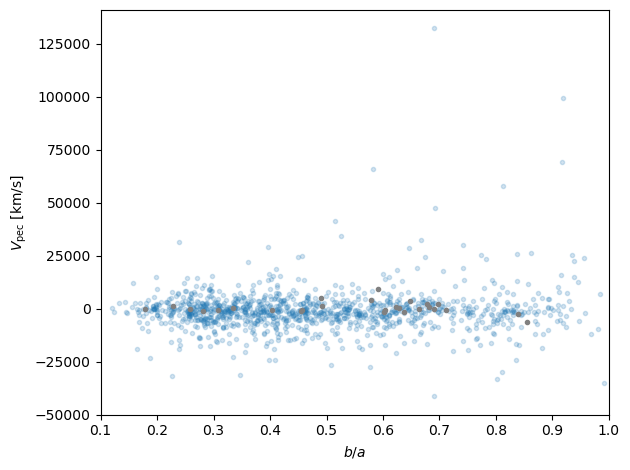

In [15]:
plt.figure(tight_layout=True)

plt.plot(SGA_TF['BA'][~dwarf_boolean], SGA_TF['V_PEC'][~dwarf_boolean], '.', alpha=0.2)
plt.plot(SGA_TF['BA'][dwarf_boolean], SGA_TF['V_PEC'][dwarf_boolean], '.', c='gray')

plt.xlim([0.1, 1])
# plt.ylim([-20000, 20000])

plt.xlabel('$b/a$')
plt.ylabel(r'$V_\text{pec}$ [km/s]');

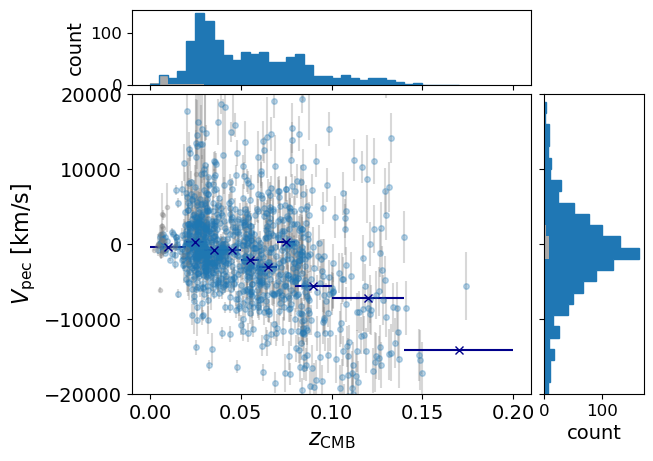

In [35]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.14, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax.errorbar(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
            SGA_TF['V_PEC'][~dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
            yerr=SGA_TF['VERR_PEC'][~dwarf_boolean],
            fmt='o', 
            markersize=4, 
            alpha=0.3, 
            ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI_CMB'][dwarf_boolean], 
            SGA_TF['V_PEC'][dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
            yerr=SGA_TF['VERR_PEC'][dwarf_boolean],
            fmt='.', 
            color='gray',
            alpha=0.3, 
            ecolor='gray')

# Plot the mean, weighted by Vmax
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
                                    SGA_TF['V_PEC'][~dwarf_boolean], 
                                    zbins, 
                                    weights=SGA_TF['DIST_MAX'][~dwarf_boolean].to('Gpc')**3, 
                                    weighted=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue')

plt.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=16)
ax.set_ylabel(r'$V_\text{pec}$ [km/s]', fontsize=16)

ax.set_ylim((-20000, 20000))


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='tab:blue', histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.tick_params(axis='y', labelsize=12)
ax_histx.set_ylabel('count', fontsize=14)


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(SGA_TF['V_PEC'][~dwarf_boolean], 
              bins=np.arange(-20000, 20000, bin_width), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['V_PEC'][dwarf_boolean], 
              bins=np.arange(-20000, 20000, bin_width), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['V_PEC'][~dwarf_boolean], 
              bins=np.arange(-20000, 20000, bin_width), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

# ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.tick_params(axis='x', labelsize=12)
ax_histy.set_xlabel('count', fontsize=14);

# plt.savefig('../../Figures/SV/fuji_Vpec-v-zCMB_jointTFR-varyV0-perpdwarfs_20250205.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

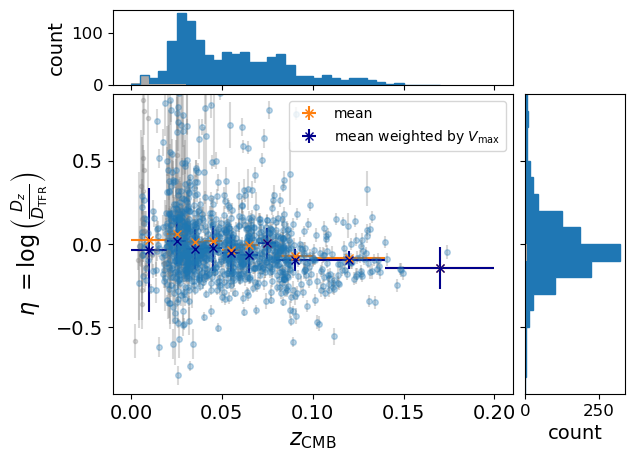

In [39]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.14, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax.errorbar(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
            SGA_TF['LOGDIST'][~dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR'][~dwarf_boolean],
            fmt='o', 
            markersize=4, 
            alpha=0.3, 
            ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI_CMB'][dwarf_boolean], 
            SGA_TF['LOGDIST'][dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR'][dwarf_boolean],
            fmt='.', 
            color='gray',
            alpha=0.3, 
            ecolor='gray')

# Plot the mean, weighted by Vmax
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
                                    SGA_TF['LOGDIST'][~dwarf_boolean], 
                                    zbins, 
                                    yerr=SGA_TF['LOGDIST_ERR'][~dwarf_boolean])
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='tab:orange', label='mean')
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
                                    SGA_TF['LOGDIST'][~dwarf_boolean], 
                                    zbins, 
                                    weights=SGA_TF['DIST_MAX'][~dwarf_boolean].to('Gpc')**3, 
                                    weighted=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='mean weighted by $V_\mathrm{max}$')

plt.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=16)
ax.set_ylabel(r'$\eta\ = \log \left(\frac{D_z}{D_{\text{TFR}}}\right)$', fontsize=16)

ax.set_ylim((-0.9, 0.9))

ax.legend()


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='tab:blue', histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.tick_params(axis='y', labelsize=12)
ax_histx.set_ylabel('count', fontsize=14)


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(SGA_TF['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST'][dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

# ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.tick_params(axis='x', labelsize=12)
ax_histy.set_xlabel('count', fontsize=14);

# plt.savefig('../../Figures/SV/fuji_logdist-v-zCMB_jointTFR-varyV0-perpdwarfs_20250217.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

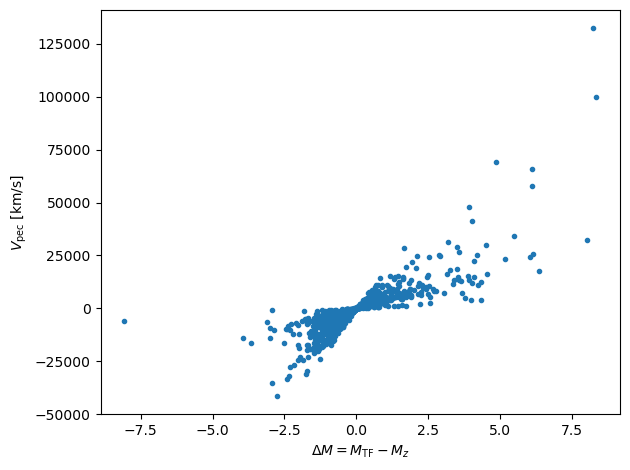

In [19]:
plt.figure(tight_layout=True)

plt.plot(SGA_TF['R_ABSMAG_SB26_TFbright'] - SGA_TF['R_ABSMAG_SB26_CORR'], 
         SGA_TF['V_PEC'], 
         '.'
        )

plt.xlabel(r'$\Delta M = M_\text{TF} - M_z$')
plt.ylabel(r'$V_\text{pec}$ [km/s]');

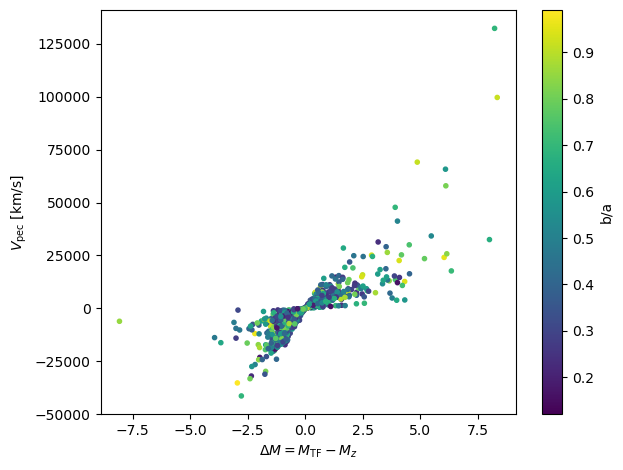

In [20]:
plt.figure(tight_layout=True)

plt.scatter(SGA_TF['R_ABSMAG_SB26_TFbright'] - SGA_TF['R_ABSMAG_SB26_CORR'], 
            SGA_TF['V_PEC'], 
            c=SGA_TF['BA'],
            marker='.', 
            # alpha=0.2
           )

plt.colorbar(label='b/a')

plt.xlabel(r'$\Delta M = M_\text{TF} - M_z$')
plt.ylabel(r'$V_\text{pec}$ [km/s]');

In [21]:
SGA_TF['SGA_ID', 'RA', 'DEC', 'V_0p33R26', 'R_ABSMAG_SB26_TFbright', 'R_ABSMAG_SB26_CORR', 'V_PEC', 'VERR_PEC'][np.abs(SGA_TF['R_ABSMAG_SB26_TFbright'] - SGA_TF['R_ABSMAG_SB26_CORR']) > 2].show_in_notebook()

idx,SGA_ID,RA,DEC,V_0p33R26,R_ABSMAG_SB26_TFbright,R_ABSMAG_SB26_CORR,V_PEC,VERR_PEC
0,1980,221.0765229904383,0.04404351172445308,265.3335545848681,-22.63751615549851,-20.233530014297678,-9555.437411860317,675.2669698932131
1,5958,215.880442955478,52.92332308171192,36.34639024582176,-15.929794293952398,-20.800878833106115,69074.48145212678,4736.612585892818
2,5964,246.57584011290885,42.33277306995234,44.65927910609046,-16.624786869604264,-19.11926249827005,15834.012759773907,1631.5353761889228
3,19762,251.9825742147375,35.91481349955137,45.565990393931486,-16.692608391005994,-18.702056395093596,8862.252897754364,1794.1579373327675
4,50360,215.93693121400503,53.99023498062971,30.75664920065232,-15.366326457290773,-18.87348649166476,18693.444754950182,1302.2211100535128
5,92954,189.86853445167645,63.37460570065662,48.17713985581944,-16.88063387202395,-20.891245198823455,41207.95981693688,2850.2701109818427
6,114405,216.79108702430176,51.32976643074304,193.774009875664,-21.57699397888619,-19.388675077383635,-11917.280884528684,768.0346170662182
7,129388,191.36956369920242,63.008901874561104,13.735752865999086,-12.646299596023574,-16.425361735464197,4878.468782005754,3255.489761238411
8,139660,194.91584295024506,27.57659701336176,29.174205757341046,-15.188092373941712,-18.242102010099888,7387.468168441097,969.9752393716971
9,158910,268.8148010938136,65.06712958819746,109.08829344682488,-19.638347748120196,-21.749458096661073,24867.371334983574,10992.393720178012
